In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import xgboost as xgb


import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

In [15]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

- - -

In [0]:
X = final['Text']
y = final['Score'][:]

In [17]:
X.shape

(9564,)

In [18]:
X_train = X[:7000 ]
X_test = X[7001:]

y_train = y[:7000]
y_test = y[7001:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7000,) (7000,)
(2563,) (2563,)


In [0]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
## Zero Padding
max_review_length = 600

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(7000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

# Single layer LSTM Model

In [21]:
top_words = 5000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data=(X_test, y_test))# Final evaluation of the model
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 7000 samples, validate on 2563 samples
Epoch 1/10
7000/7000 [==============================] - 55s 8ms/step - loss: 2.0669 - acc: 0.8319 - val_loss: 2.7431 - val_acc: 0.8272
Epoch 2/10
7000/7000 [==============================] - 53s 8ms/step - loss: 2.6123 - acc: 0.8361 - val_loss: 2.7431 - val_acc: 0.8272
Epoch 3/10
7000/7000 [==============================] - 52s 7ms/step - loss: 2.6123 - acc: 0.8361 - val_loss: 2.7431 - val_acc: 0.8272
Epoch 4/10
7000/7000 [==============================] - 52s 7ms/step - loss: 2.6123 - acc: 0.8361 - val_loss: 2.7431 - val_acc: 0.8272
Epoch 5/10
7000/7000 [==============================] - 51s 7ms/step - loss: 2.6123 - acc: 0.8361 - val_loss: 2.7431 - val_acc: 0.8272
Epoch 6/10
7000/7000 [==============================] - 51s 7ms/step - loss: 2.6123 - acc: 0.8361 - val_loss: 2.7431 - val_acc: 0.8272
Epoch 7/10
7000/7000 [==============================] - 51s 7ms/step - loss: 2.6123 - acc: 0.8

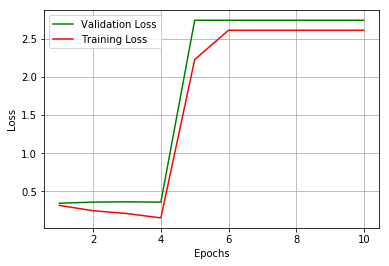

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,10+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

- - -

# 2-Layer LSTM model

In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras import regularizers

embedding_vecor_length = 32
top_words = 50000

model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(32, return_sequences=True, kernel_initializer = 'random_uniform',W_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(LSTM(32,W_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, kernel_initializer="random_uniform", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 600, 32)           1600032   
_________________________________________________________________
lstm_12 (LSTM)               (None, 600, 32)           8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 600, 32)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,616,705
Trainable params: 1,616,705
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X_train, y_train,
                    nb_epoch=10, 
                    batch_size=512,
                   validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 7000 samples, validate on 2563 samples
Epoch 1/10
7000/7000 [==============================] - 30s 4ms/step - loss: 0.7131 - acc: 0.8147 - val_loss: 0.6419 - val_acc: 0.8279
Epoch 2/10
7000/7000 [==============================] - 26s 4ms/step - loss: 0.5347 - acc: 0.8361 - val_loss: 0.5151 - val_acc: 0.8279
Epoch 3/10
7000/7000 [==============================] - 26s 4ms/step - loss: 0.4924 - acc: 0.8361 - val_loss: 0.4876 - val_acc: 0.8279
Epoch 4/10
7000/7000 [==============================] - 26s 4ms/step - loss: 0.4829 - acc: 0.8361 - val_loss: 0.4798 - val_acc: 0.8279
Epoch 5/10
7000/7000 [==============================] - 27s 4ms/step - loss: 0.4692 - acc: 0.8361 - val_loss: 0.4669 - val_acc: 0.8279
Epoch 6/10
7000/7000 [==============================] - 26s 4ms/step - loss: 0.4358 - acc: 0.8361 - val_loss: 0.4163 - val_acc: 0.8279
Epoch 7/10
7000/7000 [==============================] - 26s 4ms/step - loss: 0.3352 - acc: 0.8604 - val_loss: 0.3460 - val_acc: 0.8634
Epoch 8

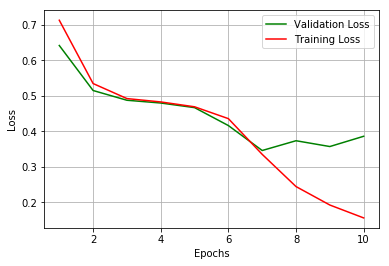

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,10+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

# 2 layer LSTM Model with Dropout = 0.8

In [24]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras import regularizers

embedding_vecor_length = 32
top_words = 50000

model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(32, return_sequences=True, kernel_initializer = 'random_uniform',W_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.8))
model.add(LSTM(32,W_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.8))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, kernel_initializer="random_uniform", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           1600032   
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 32)           8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,616,705
Trainable params: 1,616,705
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train, y_train, batch_size = 256, epochs = 10, verbose = 1, validation_data=(X_test, y_test))# Final evaluation of the model
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 7000 samples, validate on 2563 samples
Epoch 1/10
7000/7000 [==============================] - 52s 7ms/step - loss: 0.6392 - acc: 0.8211 - val_loss: 0.5020 - val_acc: 0.8279
Epoch 2/10
7000/7000 [==============================] - 52s 7ms/step - loss: 0.5024 - acc: 0.8353 - val_loss: 0.4705 - val_acc: 0.8279
Epoch 3/10
7000/7000 [==============================] - 52s 7ms/step - loss: 0.4407 - acc: 0.8367 - val_loss: 0.3770 - val_acc: 0.8435
Epoch 4/10
7000/7000 [==============================] - 51s 7ms/step - loss: 0.2926 - acc: 0.8991 - val_loss: 0.3744 - val_acc: 0.8740
Epoch 5/10
7000/7000 [==============================] - 52s 7ms/step - loss: 0.2092 - acc: 0.9364 - val_loss: 0.4006 - val_acc: 0.8790
Epoch 6/10
7000/7000 [==============================] - 52s 7ms/step - loss: 0.1577 - acc: 0.9616 - val_loss: 0.4104 - val_acc: 0.8779
Epoch 7/10
7000/7000 [==============================] - 51s 7ms/step - loss: 0.1198 - acc: 0.9746 - val_loss: 0.4298 - val_acc: 0.8736
Epoch 8

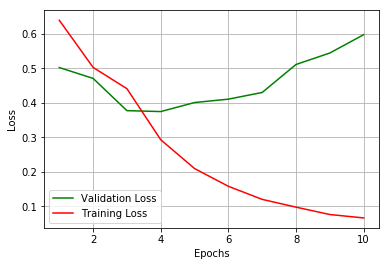

In [26]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,10+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

# 2 layer LSTM Model with Dropout = 0.2

In [27]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras import regularizers

embedding_vecor_length = 32
top_words = 50000

model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(32, return_sequences=True, kernel_initializer = 'random_uniform',W_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))
model.add(LSTM(32,W_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, kernel_initializer="random_uniform", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 32)           1600032   
_________________________________________________________________
lstm_4 (LSTM)                (None, 600, 32)           8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 600, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,616,705
Trainable params: 1,616,705
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data=(X_test, y_test))# Final evaluation of the model
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 7000 samples, validate on 2563 samples
Epoch 1/10
7000/7000 [==============================] - 103s 15ms/step - loss: 0.5513 - acc: 0.8297 - val_loss: 0.4807 - val_acc: 0.8279
Epoch 2/10
7000/7000 [==============================] - 102s 15ms/step - loss: 0.4146 - acc: 0.8397 - val_loss: 0.3687 - val_acc: 0.8595
Epoch 3/10
7000/7000 [==============================] - 102s 15ms/step - loss: 0.2395 - acc: 0.9153 - val_loss: 0.3181 - val_acc: 0.8837
Epoch 4/10
7000/7000 [==============================] - 102s 15ms/step - loss: 0.1450 - acc: 0.9574 - val_loss: 0.3513 - val_acc: 0.8872
Epoch 5/10
7000/7000 [==============================] - 102s 15ms/step - loss: 0.1009 - acc: 0.9733 - val_loss: 0.3630 - val_acc: 0.8736
Epoch 6/10
7000/7000 [==============================] - 101s 14ms/step - loss: 0.0737 - acc: 0.9829 - val_loss: 0.4797 - val_acc: 0.8829
Epoch 7/10
7000/7000 [==============================] - 102s 15ms/step - loss: 0.0531 - acc: 0.9900 - val_loss: 0.4536 - val_acc: 

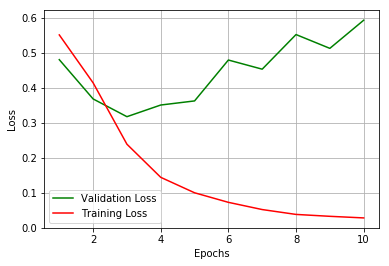

In [29]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,10+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

# 3 layer LSTM Model with Dropout = 0.8

In [37]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras import regularizers

embedding_vecor_length = 32
top_words = 50000

model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(32, return_sequences=True, kernel_initializer = 'random_uniform',W_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.8))
model.add(LSTM(64,W_regularizer=regularizers.l2(0.001),return_sequences = True))
model.add(Dropout(0.8))
model.add(LSTM(32,W_regularizer=regularizers.l2(0.001), return_sequences = False))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, kernel_initializer="random_uniform", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=False, kernel_regularizer=<keras.reg...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 600, 32)           1600032   
_________________________________________________________________
lstm_18 (LSTM)               (None, 600, 32)           8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 600, 32)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 600, 64)           24832     
_________________________________________________________________
dropout_14 (Dropout)         (None, 600, 64)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
__________

In [38]:
history = model.fit(X_train, y_train, batch_size = 512, epochs = 10, verbose = 1, validation_data=(X_test, y_test))# Final evaluation of the model
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 7000 samples, validate on 2563 samples
Epoch 1/10
7000/7000 [==============================] - 43s 6ms/step - loss: 0.7540 - acc: 0.8094 - val_loss: 0.5736 - val_acc: 0.8279
Epoch 2/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.6007 - acc: 0.8337 - val_loss: 0.5617 - val_acc: 0.8279
Epoch 3/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.5677 - acc: 0.8354 - val_loss: 0.5325 - val_acc: 0.8279
Epoch 4/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.5303 - acc: 0.8361 - val_loss: 0.4984 - val_acc: 0.8279
Epoch 5/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.4581 - acc: 0.8470 - val_loss: 0.4171 - val_acc: 0.8517
Epoch 6/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.3268 - acc: 0.8976 - val_loss: 0.4087 - val_acc: 0.8408
Epoch 7/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.2447 - acc: 0.9347 - val_loss: 0.4100 - val_acc: 0.8549
Epoch 8

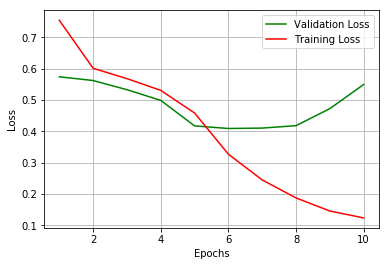

In [39]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,10+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

# 3 layer LSTM Model with Dropout = 0.5

In [40]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras import regularizers

embedding_vecor_length = 32
top_words = 50000

model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(32, return_sequences=True, kernel_initializer = 'random_uniform',W_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(LSTM(64,W_regularizer=regularizers.l2(0.001),return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(128,W_regularizer=regularizers.l2(0.001), return_sequences = False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, kernel_initializer="random_uniform", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=False, kernel_regularizer=<keras.reg...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 600, 32)           1600032   
_________________________________________________________________
lstm_21 (LSTM)               (None, 600, 32)           8320      
_________________________________________________________________
dropout_16 (Dropout)         (None, 600, 32)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 600, 64)           24832     
_________________________________________________________________
dropout_17 (Dropout)         (None, 600, 64)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
__________

In [41]:
history = model.fit(X_train, y_train, batch_size = 512, epochs = 10, verbose = 1, validation_data=(X_test, y_test))# Final evaluation of the model
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 7000 samples, validate on 2563 samples
Epoch 1/10
7000/7000 [==============================] - 43s 6ms/step - loss: 0.7378 - acc: 0.8134 - val_loss: 0.5823 - val_acc: 0.8279
Epoch 2/10
7000/7000 [==============================] - 40s 6ms/step - loss: 0.5635 - acc: 0.8361 - val_loss: 0.5491 - val_acc: 0.8279
Epoch 3/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.5239 - acc: 0.8361 - val_loss: 0.5185 - val_acc: 0.8279
Epoch 4/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.4761 - acc: 0.8361 - val_loss: 0.4498 - val_acc: 0.8279
Epoch 5/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.3379 - acc: 0.8741 - val_loss: 0.3888 - val_acc: 0.8642
Epoch 6/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.2283 - acc: 0.9211 - val_loss: 0.3601 - val_acc: 0.8712
Epoch 7/10
7000/7000 [==============================] - 39s 6ms/step - loss: 0.1599 - acc: 0.9521 - val_loss: 0.4427 - val_acc: 0.8709
Epoch 8

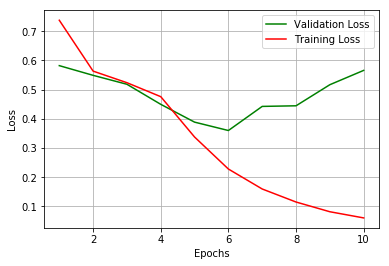

In [42]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,10+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

- - -

# Conclusion
- The data points used for training in this notebook is about 10k due to limited computing power.Accuracy can be further improved using more number of training data points.L2 regularization is useful to prevent overfitting in the 2 Layers LSTM model.

In [45]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Numer of Layers","Dropout", "Accuracy"]

x.add_row(["1","NO", '82.72%'])
x.add_row(["2",0.5, '86.73%'])
x.add_row(["2",0.8, '85.76%'])
x.add_row(["2",0.2, '87.36%'])
x.add_row(["3",0.8, '87.12%'])
x.add_row(["3",0.5, '86.62%'])





print(x)

+-----------------+---------+----------+
| Numer of Layers | Dropout | Accuracy |
+-----------------+---------+----------+
|        1        |    NO   |  82.72%  |
|        2        |   0.5   |  86.73%  |
|        2        |   0.8   |  85.76%  |
|        2        |   0.2   |  87.36%  |
|        3        |   0.8   |  87.12%  |
|        3        |   0.5   |  86.62%  |
+-----------------+---------+----------+
